# Customer Churn Prediction - Data Science in Telco

Data Source    : https://www.dqlab.id/


Objective	: Customer Churn Prediction

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import pickle
from pathlib import Path

## Load Data

In [2]:
df_load = pd.read_csv('dqlab_telco_final.csv')

## Exploratory Data Analysis

In [3]:
df_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6950 entries, 0 to 6949
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UpdatedAt         6950 non-null   int64  
 1   customerID        6950 non-null   int64  
 2   gender            6950 non-null   object 
 3   SeniorCitizen     6950 non-null   object 
 4   Partner           6950 non-null   object 
 5   tenure            6950 non-null   int64  
 6   PhoneService      6950 non-null   object 
 7   StreamingTV       6950 non-null   object 
 8   InternetService   6950 non-null   object 
 9   PaperlessBilling  6950 non-null   object 
 10  MonthlyCharges    6950 non-null   float64
 11  TotalCharges      6950 non-null   float64
 12  Churn             6950 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 706.0+ KB


In [4]:
df_load.shape

(6950, 13)

In [5]:
df_load.head()

,UpdatedAt,customerID,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,202006,45759018157,Female,No,Yes,1,No,No,Yes,Yes,29.85,29.85,No
1,202006,45315483266,Male,No,Yes,60,Yes,No,No,Yes,20.50,1198.80,No
2,202006,45236961615,Male,No,No,5,Yes,Yes,Yes,No,104.10,541.90,Yes
3,202006,45929827382,Female,No,Yes,72,Yes,Yes,Yes,Yes,115.50,8312.75,No
4,202006,45305082233,Female,No,Yes,56,Yes,Yes,Yes,No,81.25,4620.40,No


Identify number of customers

In [6]:
df_load.customerID.nunique()

6950

There are 6950 customers have been identified. Let's plot the churn propotion.

Yes Churn : 1836
No Churn : 5114


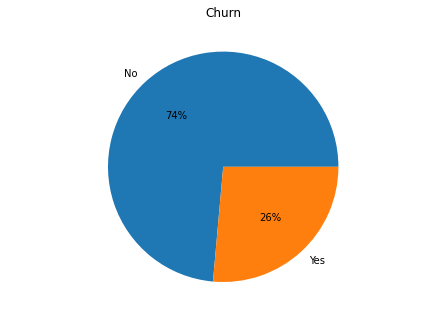

In [7]:
print('Yes Churn :', df_load['Churn'][df_load['Churn'] == 'Yes'].count())
print('No Churn :', df_load['Churn'][df_load['Churn'] == 'No'].count())
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
labels = ['No','Yes']
churn = df_load.Churn.value_counts()
ax.pie(churn, labels=labels, autopct='%.0f%%')
ax.set_title('Churn')
plt.show()

Next, we identify the distribution of **MonthlyCharges**, **TotalCharges** and **Tenure**.

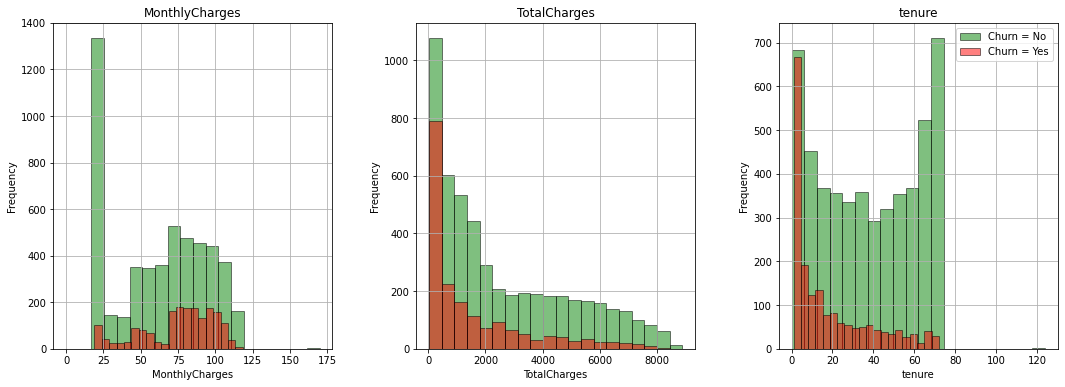

In [8]:
numerical_features = ['MonthlyCharges', 'TotalCharges','tenure']
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
df_load[df_load.Churn == 'No'][numerical_features].hist(bins=20, color='green', edgecolor = 'black', alpha=0.5, ax=ax, label='Churn = No')
df_load[df_load.Churn == 'Yes'][numerical_features].hist(bins=20, color='red', edgecolor = 'black', alpha=0.5, ax=ax, label='Churn = Yes')

for i in range(3):
    ax[i].set_xlabel(numerical_features[i])
    ax[i].set_ylabel('Frequency')
    
plt.legend()
plt.show()

Plot churn proportion for each features

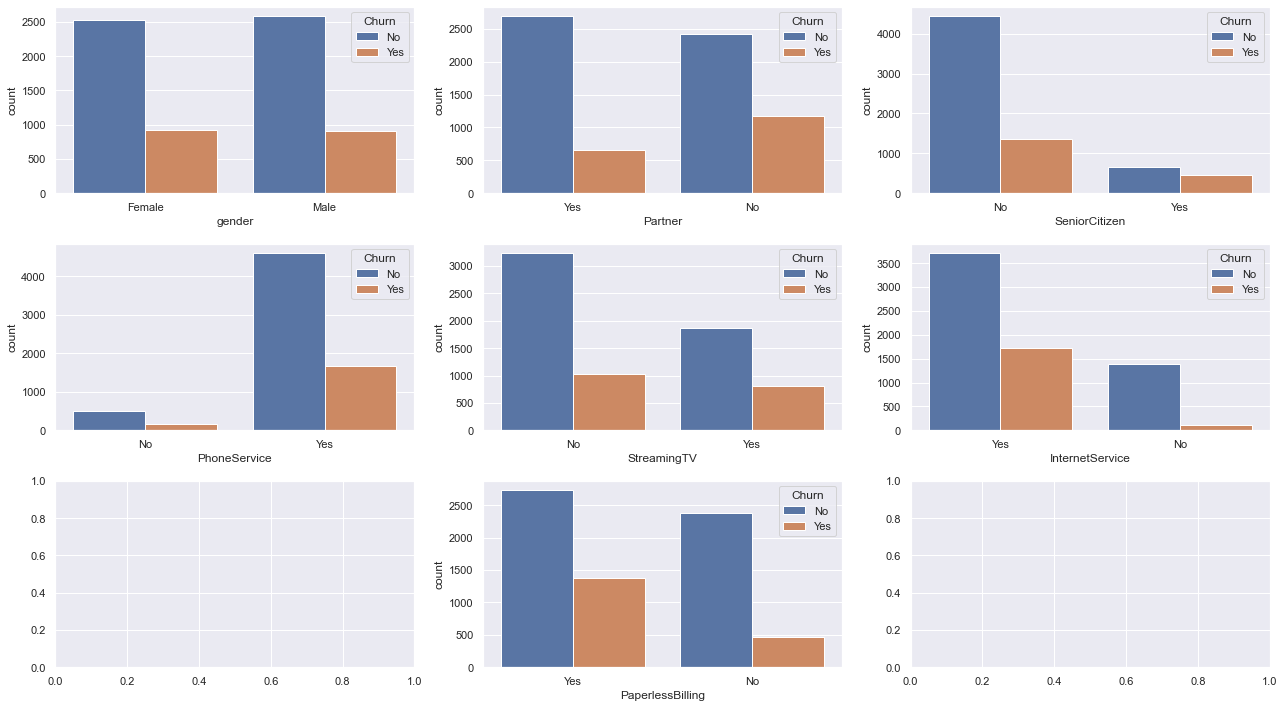

In [9]:
sns.set(style='darkgrid')
fig, ax = plt.subplots(3, 3, figsize=(18, 10))
sns.countplot(data=df_load, x='gender', hue='Churn', ax=ax[0][0])
sns.countplot(data=df_load, x='Partner', hue='Churn', ax=ax[0][1])
sns.countplot(data=df_load, x='SeniorCitizen', hue='Churn', ax=ax[0][2])
sns.countplot(data=df_load, x='PhoneService', hue='Churn', ax=ax[1][0])
sns.countplot(data=df_load, x='StreamingTV', hue='Churn', ax=ax[1][1])
sns.countplot(data=df_load, x='InternetService', hue='Churn', ax=ax[1][2])
sns.countplot(data=df_load, x='PaperlessBilling', hue='Churn', ax=ax[2][1])
plt.tight_layout()
plt.show()

Based on the results above:

1. There are 1836 (74%) customers who churn and 5114 (26%) customers who did not churn. The percentage the customers who did not churn is higher than the customers who did.
2. The smaller monthly charges is charged, the possibility of churn is low.
3. There is no high tendency of total charges to the customers churn.
4. The long period of tenure, the possibility of customers churn is low.
5. The customers churn are dominated by:
    * The customers are female,
    * They have phone service,
    * They does not have a partner,
    * They are not senior citizen,
    * They does not have streaming TV,
    * They have internet service,
    * and They use paper less billing method

Next, we remove uneccessary columns, there are customer ID (customerID) and update time (UpdateAt).

In [10]:
cleaned_df = df_load.drop(['customerID','UpdatedAt'], axis=1)

In [11]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6950 entries, 0 to 6949
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            6950 non-null   object 
 1   SeniorCitizen     6950 non-null   object 
 2   Partner           6950 non-null   object 
 3   tenure            6950 non-null   int64  
 4   PhoneService      6950 non-null   object 
 5   StreamingTV       6950 non-null   object 
 6   InternetService   6950 non-null   object 
 7   PaperlessBilling  6950 non-null   object 
 8   MonthlyCharges    6950 non-null   float64
 9   TotalCharges      6950 non-null   float64
 10  Churn             6950 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 597.4+ KB


In [35]:
cleaned_df.head()

,gender,SeniorCitizen,Partner,tenure,PhoneService,StreamingTV,InternetService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,1,No,No,Yes,Yes,29.85,29.85,No
1,Male,No,Yes,60,Yes,No,No,Yes,20.50,1198.80,No
2,Male,No,No,5,Yes,Yes,Yes,No,104.10,541.90,Yes
3,Female,No,Yes,72,Yes,Yes,Yes,Yes,115.50,8312.75,No
4,Female,No,Yes,56,Yes,Yes,Yes,No,81.25,4620.40,No


Now, we have 6950 rows data and 11 columns. Next, we calculate the correlation for each features to churn feature. Because some features are object type, we have to encoding these values to numeric.

## Encoding

In [37]:
for column in cleaned_df.columns:
    if cleaned_df[column].dtype == np.number: continue
    # Apply encoder to all features
    cleaned_df[column] = LabelEncoder().fit_transform(cleaned_df[column])
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6950 entries, 0 to 6949
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            6950 non-null   int64  
 1   SeniorCitizen     6950 non-null   int64  
 2   Partner           6950 non-null   int64  
 3   tenure            6950 non-null   int64  
 4   PhoneService      6950 non-null   int64  
 5   StreamingTV       6950 non-null   int64  
 6   InternetService   6950 non-null   int64  
 7   PaperlessBilling  6950 non-null   int64  
 8   MonthlyCharges    6950 non-null   float64
 9   TotalCharges      6950 non-null   float64
 10  Churn             6950 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 597.4 KB


In [39]:
corr = cleaned_df.corr()
corr
corr.drop('Churn',axis=0)['Churn'].sort_values(ascending=False).reset_index()

,index,Churn
0,InternetService,0.227063
1,PaperlessBilling,0.192031
2,MonthlyCharges,0.191932
3,SeniorCitizen,0.150474
4,StreamingTV,0.063330
5,PhoneService,0.014087
6,gender,-0.008437
7,Partner,-0.148478
8,TotalCharges,-0.199105
9,tenure,-0.351968


According to correlation between each featrues to Churn featrue:

* The internet service has strong correlation to churn. This correlation direction is positive. It indicates, the customers who churn that have the internet service.
* The paper less billing is the second position of strong correlation to churn, where the correlation direction is positive. It indicates, the customers who churn that use the paper less billing method.
* The other features that have positive direcation of correlation are monthly charges, senior citizen, streaming Tv and phone service. These features are on third, forth, fifth and sixth position respectively. These correlation indicates, the customers who churn that have high monthly charges, they are not senior citizen, they do not have streaming TV and they have less phone service.
* There are four features that have inverse correlation to churn feature, gender, partner, total charges and tenure. These features indicates the customers who churn mostly are female, they do not have partner, they have less of total charges and thet have less of tenure.

## Generate Model

In [40]:
X = cleaned_df.drop(['Churn'], axis=1)
y = cleaned_df['Churn']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('shape of x_train:', x_train.shape)
print('shape of y_train:', y_train.shape)

shape of x_train: (4865, 10)
shape of y_train: (4865,)


We use the following features as the input variables for our model.

In [41]:
X.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'tenure', 'PhoneService',
       'StreamingTV', 'InternetService', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges'],
      dtype='object')

Check the proportion of customers churn of target data

In [42]:
y_train.value_counts(normalize=True)

0    0.734841
1    0.265159
Name: Churn, dtype: float64

In [43]:
print('shape of x_train:', x_test.shape)
print('shape of y_train:', y_test.shape)

shape of x_train: (2085, 10)
shape of y_train: (2085,)


Check the proportion of customers churn of target data

In [44]:
y_test.value_counts(normalize=True)

0    0.738129
1    0.261871
Name: Churn, dtype: float64

## Logistic Regression

Create model by using logistic regression

In [45]:
log_model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False).fit(x_train,y_train)

### Train Data
Predict the customers churn by using train data

In [46]:
y_train_pred = log_model.predict(x_train)

In [47]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      3575
           1       0.65      0.50      0.56      1290

    accuracy                           0.80      4865
   macro avg       0.74      0.70      0.71      4865
weighted avg       0.78      0.80      0.79      4865



In [48]:
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))
confusion_matrix_df

,No churn,Churn
No churn,3225,350
Churn,647,643


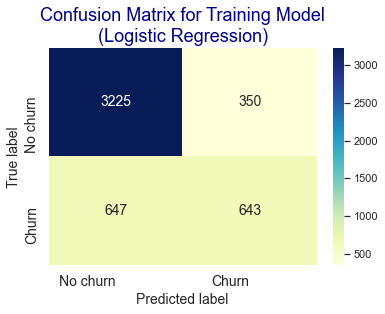

In [49]:
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Training Model\n(Logistic Regression)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

According to confusion matrix of training model data by using logistic regression:

1. training model can predicts 3225 customers who did not churn and they actually did not, 
2. training model incorrect to predicts about 350 customers who churn, but they actually did not churn,
3. training model incorrect to predicts about 647 customers who did not churn, but they actually churn,
4. training model can predicts 643 customers who churn and they actually did.

The accuracy of this model is 80% to predict the customers who did not churn and churn. This model is correct to predict the customers who actually churn about 65% of precission. Let us calculate the model by using test data.

### Test Data
Predict the customers churn by using test data

In [50]:
y_test_pred = log_model.predict(x_test)

In [51]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1539
           1       0.64      0.49      0.56       546

    accuracy                           0.80      2085
   macro avg       0.74      0.70      0.71      2085
weighted avg       0.78      0.80      0.79      2085



In [52]:
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))
confusion_matrix_df

,No churn,Churn
No churn,1389,150
Churn,277,269


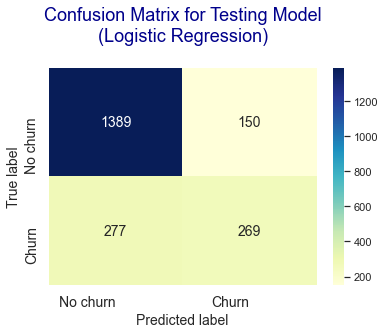

In [53]:
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Testing Model\n(Logistic Regression)\n', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

According to confusion matrix of testing model data by using logistic regression:

1. testing model can predicts 1389 customers who did not churn and they actually did not, 
2. testing model incorrect to predicts about 150 customers who churn, but they actually did not churn,
3. testing model incorrect to predicts about 277 customers who did not churn, but they actually churn,
4. testing model can predicts 269 customers who churn and they actually did.

The accuracy of this model is 80% to predict the customers who did not churn and churn. This model is correct to predict the customers who actually churn about 64% of precission.

## Random Forest Classifier

In [54]:
rdf_model = RandomForestClassifier().fit(x_train,y_train)

### Training Data
Predict the customers churn by using train data

In [55]:
y_train_pred = rdf_model.predict(x_train)

In [56]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3575
           1       0.99      0.99      0.99      1290

    accuracy                           1.00      4865
   macro avg       0.99      0.99      0.99      4865
weighted avg       1.00      1.00      1.00      4865



In [57]:
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train,y_train_pred)), ('No churn','Churn'), ('No churn','Churn'))
confusion_matrix_df

,No churn,Churn
No churn,3566,9
Churn,12,1278


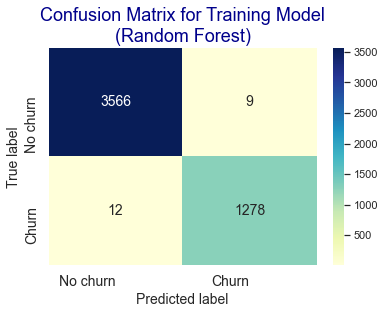

In [58]:
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Training Model\n(Random Forest)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

According to confusion matrix of training model data by using random forest classifier:

1. training model can predicts 3566 customers who did not churn and they actually did not, 
2. training model incorrect to predicts about 9 customers who churn, but they actually did not churn,
3. training model incorrect to predicts about 12 customers who did not churn, but they actually churn,
4. training model can predicts 1278 customers who churn and they actually did.

The accuracy of this model is 100% to predict the customers who did not churn and churn. This model is correct to predict the customers who actually churn about 99% of precission. Let us calculate the model by using test data.

### Testing Data
Predict the customers churn by using testing data

In [59]:
y_test_pred = rdf_model.predict(x_test)

In [60]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1539
           1       0.59      0.47      0.52       546

    accuracy                           0.78      2085
   macro avg       0.71      0.68      0.69      2085
weighted avg       0.76      0.78      0.77      2085



In [61]:
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))
confusion_matrix_df

,No churn,Churn
No churn,1360,179
Churn,288,258


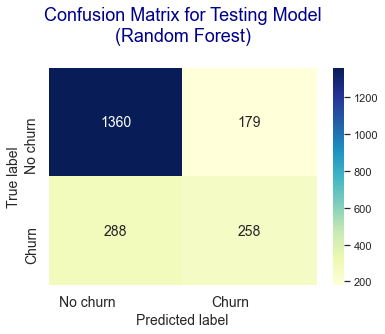

In [62]:
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Testing Model\n(Random Forest)\n', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

According to confusion matrix of testing model data by using random forest classifier:

1. testing model can predicts 1360 customers who did not churn and they actually did not, 
2. testing model incorrect to predicts about 179 customers who churn, but they actually did not churn,
3. testing model incorrect to predicts about 288 customers who did not churn, but they actually churn,
4. testing model can predicts 258 customers who churn and they actually did.

The accuracy of this model is 78% to predict the customers who did not churn and churn. This model is correct to predict the customers who actually churn about 59% of precission.

## Gradient Boosting Classifier

### Training Data

In [63]:
gbt_model = GradientBoostingClassifier().fit(x_train,y_train)

In [64]:
y_train_pred = gbt_model.predict(x_train)

In [65]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      3575
           1       0.70      0.53      0.60      1290

    accuracy                           0.82      4865
   macro avg       0.77      0.72      0.74      4865
weighted avg       0.81      0.82      0.81      4865



In [66]:
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_train, y_train_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))
confusion_matrix_df

,No churn,Churn
No churn,3286,289
Churn,606,684


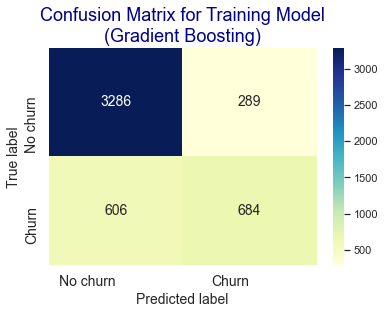

In [67]:
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Training Model\n(Gradient Boosting)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

According to confusion matrix of training model data by using gradient boosting regression:

1. training model can predicts 3286 customers who did not churn and they actually did not, 
2. training model incorrect to predicts about 289 customers who churn, but they actually did not churn,
3. training model incorrect to predicts about 606 customers who did not churn, but they actually churn,
4. training model can predicts 684 customers who churn and they actually did.

The accuracy of this model is 82% to predict the customers who did not churn and churn. This model is correct to predict the customers who actually churn about 70% of precision.

### Testing Data

In [68]:
y_test_pred = gbt_model.predict(x_test)

In [69]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1539
           1       0.64      0.48      0.55       546

    accuracy                           0.79      2085
   macro avg       0.74      0.69      0.71      2085
weighted avg       0.78      0.79      0.78      2085



In [70]:
confusion_matrix_df = pd.DataFrame((confusion_matrix(y_test, y_test_pred)), ('No churn', 'Churn'), ('No churn', 'Churn'))
confusion_matrix_df

,No churn,Churn
No churn,1394,145
Churn,285,261


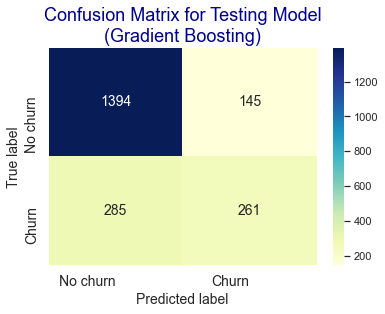

In [71]:
plt.figure()
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={'size': 14}, fmt='d', cmap='YlGnBu')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.title('Confusion Matrix for Testing Model\n(Gradient Boosting)', fontsize=18, color='darkblue')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

According to confusion matrix of testing model data by using gradient boosting regression:

1. testing model can predicts 1394 customers who did not churn and they actually did not, 
2. testing model incorrect to predicts about 145 customers who churn, but they actually did not churn,
3. testing model incorrect to predicts about 285 customers who did not churn, but they actually churn,
4. testing model can predicts 261 customers who churn and they actually did.

The accuracy of this model is 79% to predict the customers who did not churn and churn. This model is correct to predict the customers who actually churn about 64% of precission.

## Summary

The appropriate model has a good indicator in training phase and also testing phase. There are three classification of the indicator between training phase and testing phase:

#### 1. Overfitting
The model has a good prediction of target data in training phase, but does not has a good prediction in testing phase.
#### 2. Underfitting
The model has a low performance of prediction to predict the target data in training phase, but has a good prediction in testing phase.
#### 3. Appropriate-Fitting
The model has a good prediction quality of target data in training phase as well as in testing phase.

The classification model to predict the customers churn has been tried by using Logistic Regression, Random Forest Calssifier, and Gradient Boosting Calssifier. The logistic regression model gives the better performance than two others moethods because the accuracy in training phase and testing phase are equal. For this condition, the performance of two remaining model methods are overfitting.

Next, we can save the logistic regressor model for this case as pickel data format, the save command is as follows:

```
pickle.dump(log_model, open('best_model_churn.pkl', 'wb'))
```

This command will produce the file of best_model_churn.pkl that can be used to predict further customers churn data

In [72]:
pickle.dump(log_model, open('best_model_churn.pkl', 'wb'))

By using this model, we can predict the customers churn with input variable as mentioned before in correlation condition above.